In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-oxfordiiit-pet-dataset/images/american_pit_bull_terrier_16.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/leonberger_200.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/english_cocker_spaniel_35.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/Siamese_67.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/boxer_77.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/saint_bernard_146.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/american_bulldog_37.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/Sphynx_239.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/Egyptian_Mau_164.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/Birman_116.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/english_setter_178.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/Siamese_110.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/newfoundland_39.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/pug_84.jpg
/kaggle/input/the-oxfordiiit-pet-dataset/images/yor

In [3]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

2025-07-15 17:32:25.437490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752600745.694079      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752600745.775032      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()
    
    return orig_img, mask_img

In [5]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
        single_img = single_img/256.
        X[index] = single_img
        
        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) 
        single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask
    return X, y

In [6]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [7]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [8]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output
    """
    # Input size represents the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini-blocks with different max-pooling, dropout, and filter parameters
    # Observe that the filters are increasing as we go deeper into the network, which will increase the
    # channels of the image
    cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0], n_filters*2, dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4, dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Decoder includes multiple mini-blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1], n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1], n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1], n_filters)

    # Complete the model with 1 3x3 convolution layer (same as the previous Conv layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [10]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

2025-07-15 17:33:42.532552: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.7Q7NWG_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.7Q7NWG_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [11]:
def resize(input_image, input_mask):
    # Resize input image to 128x128
    resized_image = tf.image.resize(images=input_image, size=(128, 128))
    
    # Resize segmentation mask to 128x128
    resized_mask = tf.image.resize(images=input_mask, size=(128, 128))
    
    return resized_image, resized_mask
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask
def normalize(input_image, input_mask):
    return tf.cast(input_image, tf.float32) / 255.0, input_mask - 1
def load_image(datapoint, augment_data=False):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    
    input_image, input_mask = resize(input_image, input_mask)
    
    if augment_data:
        input_image, input_mask = augment(input_image, input_mask)
        
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [12]:
train_dataset = dataset["train"].map(
    lambda x: load_image(x, augment_data=True),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_dataset = dataset["test"].map(
    load_image,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Prepare the training dataset:
# 1. Cache the data in memory for faster access
# 2. Shuffle the data with a buffer
# 3. Batch the data
# 4. Repeat the dataset forever (for training)
# 5. Prefetch to improve performance
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Prepare the validation dataset (first 3000 samples from test set)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
# Prepare the test dataset (next 669 samples after validation split)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

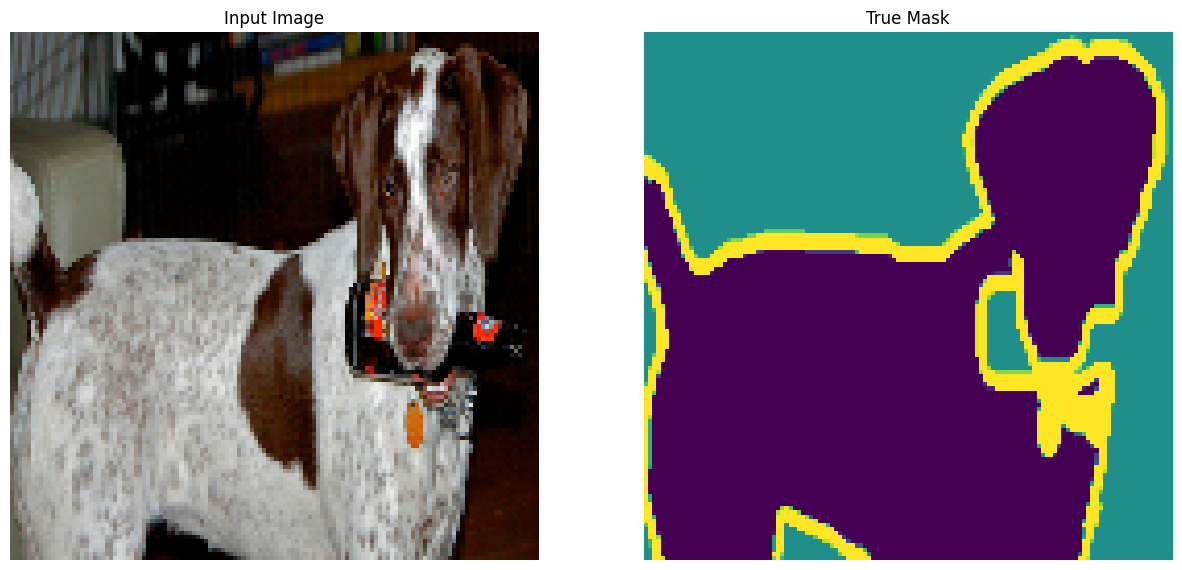

In [14]:
# Function to display input image, true mask, and predicted mask (if provided)
def display(display_list):

    plt.figure(figsize=(15, 15))
    titles = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(titles[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")

    plt.show()

# Get one batch from the training dataset
sample_batch = next(iter(train_batches))

# Randomly choose an index from the batch (0 to 63 , if batch_size = 64)
random_index = np.random.choice(sample_batch[0].shape[0])

# Extract the image and corresponding mask using the random index
sample_image = sample_batch[0][random_index]
sample_mask = sample_batch[1][random_index]

# Display the image and its true mask
display([sample_image, sample_mask])

In [16]:
def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p
def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [17]:
def build_unet_model():
    # Input layer
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder (Downsampling path)
    f1, p1 = downsample_block(inputs, 64)    # First downsampling
    f2, p2 = downsample_block(p1, 128)       # Second downsampling
    f3, p3 = downsample_block(p2, 256)       # Third downsampling
    f4, p4 = downsample_block(p3, 512)       # Fourth downsampling

    # Bottleneck (Bottom of the "U")
    bottleneck = double_conv_block(p4, 1024)

    # Decoder (Upsampling path with skip connections)
    u6 = upsample_block(bottleneck, f4, 512) # First upsampling
    u7 = upsample_block(u6, f3, 256)         # Second upsampling
    u8 = upsample_block(u7, f2, 128)         # Third upsampling
    u9 = upsample_block(u8, f1, 64)          # Fourth upsampling

    # Output layer
    outputs = layers.Conv2D(
        filters=3,                # 3 classes (background, pet, outline)
        kernel_size=1,            # 1x1 convolution
        padding="same",
        activation="softmax"      # Softmax for multi-class segmentation
    )(u9)

    # Define the model
    unet_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="U-Net")

    return unet_model
unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

In [18]:
# Set the number of epochs
NUM_EPOCHS = 4

# Calculate dataset lengths
TRAIN_LENGTH = info.splits["train"].num_examples
TEST_LENGTH = info.splits["test"].num_examples

# Define steps per epoch for training and validation
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

# Early stopping callback: stops training if validation doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

# Train the model
model_history = unet_model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_batches,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping]
)

Epoch 1/4
57/57 ━━━━━━━━━━━━━━━━━━━━ 3112s 54s/step - accuracy: 0.5246 - loss: 1.2660 - val_accuracy: 0.5823 - val_loss: 0.8209
Epoch 2/4
57/57 ━━━━━━━━━━━━━━━━━━━━ 3025s 54s/step - accuracy: 0.6911 - loss: 0.7396 - val_accuracy: 0.7179 - val_loss: 0.6709
Epoch 3/4
57/57 ━━━━━━━━━━━━━━━━━━━━ 3001s 53s/step - accuracy: 0.7245 - loss: 0.6551 - val_accuracy: 0.7537 - val_loss: 0.5928
Epoch 4/4
57/57 ━━━━━━━━━━━━━━━━━━━━ 3012s 53s/step - accuracy: 0.7401 - loss: 0.6203 - val_accuracy: 0.7750 - val_loss: 0.5495


In [20]:
def display(display_list):
    titles = ['Input Image', 'True Mask', 'Predicted Mask']
    plt.figure(figsize=(15, 5))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


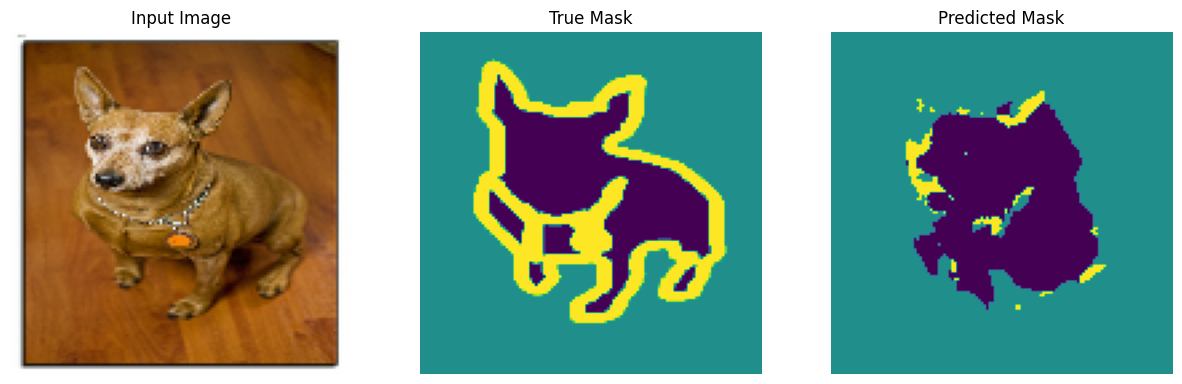

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


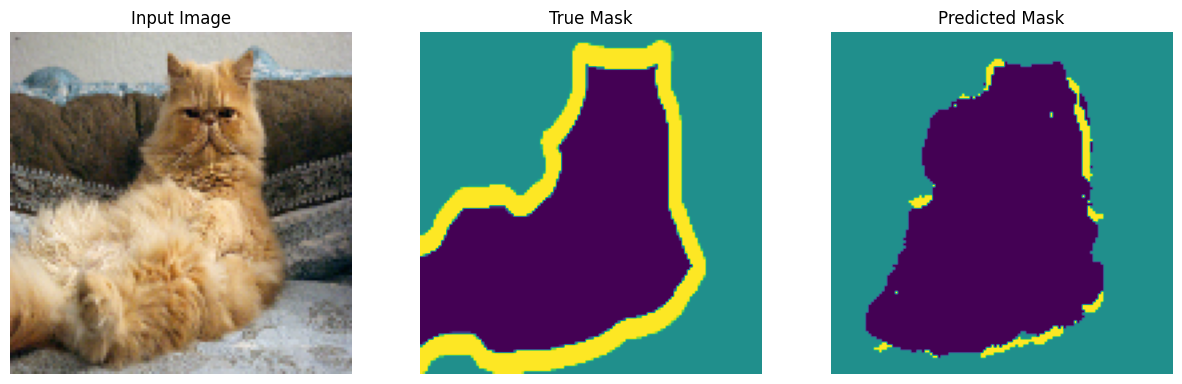

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


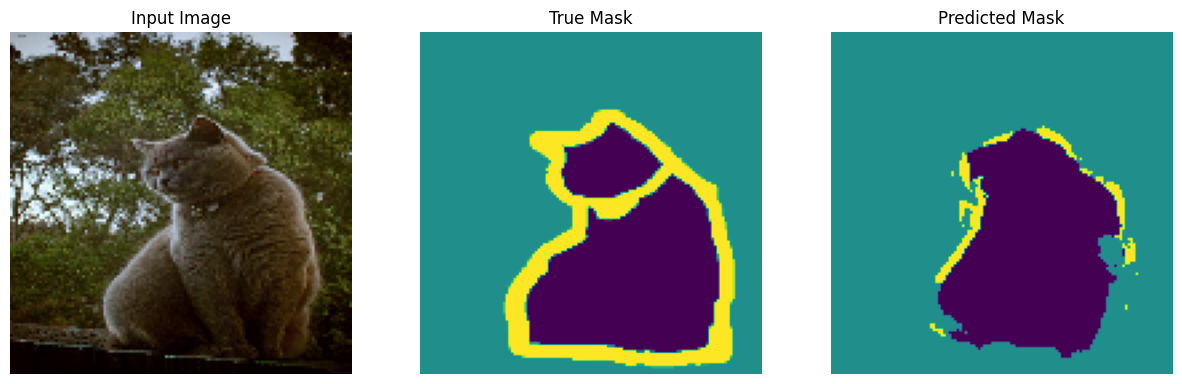

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step


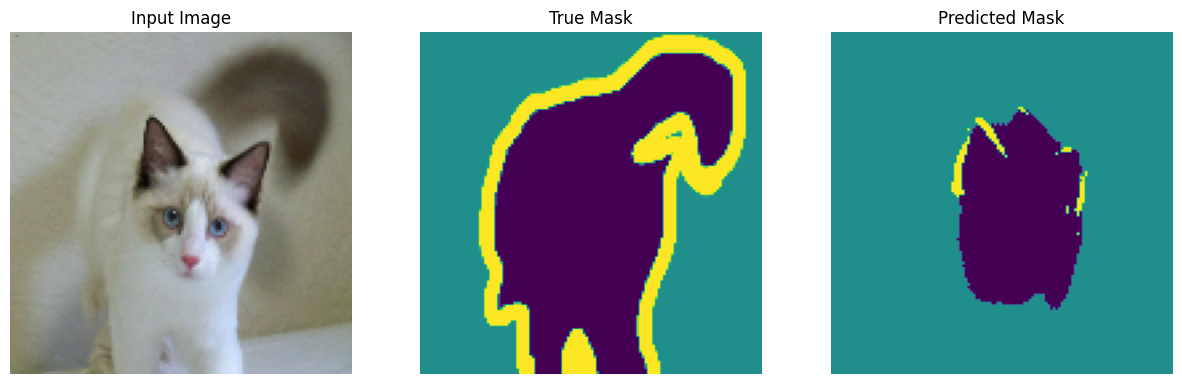

1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) # (batch_size, height, width, num_classes)
    pred_mask = pred_mask[..., tf.newaxis]
    # Take all dimensions as-is, and then add a new one at the end.
    return pred_mask[0]

def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = unet_model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
show_predictions(test_batches, 5)